# Test Non-stack Version of PPO

### Imports

In [48]:
import numpy as np
from pettingzoo.atari import boxing_v2
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import pad_observations_v0, pad_action_space_v0, resize_v1, normalize_obs_v0, frame_skip_v0, dtype_v0
from pettingzoo.utils import aec_to_parallel
import matplotlib.pyplot as plt
from collections import defaultdict

### RolloutBuffer

In [49]:
class RolloutBuffer:
    """
    Buffer to store rollout data for PPO.
    """
    def __init__(self):
        self.observations = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.returns = []
        self.advantages = []

    def store(self, obs, action, log_prob, reward, done):
        if obs.shape[-1] == 3:  # If observation has RGB channels
            obs = obs.mean(axis=-1)  # Convert to grayscale
        self.observations.append(obs)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)


    def compute_returns_and_advantages(self, policy, gamma, gae_lambda):
        """
        Computes returns and advantages using Generalized Advantage Estimation (GAE).

        Parameters:
        policy (PPOAgent): The policy network.
        gamma (float): Discount factor for rewards.
        gae_lambda (float): Lambda parameter for GAE.
        """
        if not self.observations:  # Guard clause
            print("Warning: Buffer is empty. Skipping returns and advantages computation.")
            self.returns = []
            self.advantages = []
            return
        
        values = [
            policy.forward_value(
                torch.tensor(
                    obs[np.newaxis, np.newaxis, :, :],  # Add batch and channel dimensions (1, 1, H, W)
                    dtype=torch.float32
                ) / 255.0  # Normalize
            ).item()
            for obs in self.observations
        ]


        next_value = 0 if self.dones[-1] else values[-1]

        # GAE computation
        returns = []
        advantages = []
        gae = 0
        for step in reversed(range(len(self.rewards))):
            delta = self.rewards[step] + gamma * next_value * (1 - self.dones[step]) - values[step]
            gae = delta + gamma * gae_lambda * (1 - self.dones[step]) * gae
            advantages.insert(0, gae)
            next_value = values[step]
            returns.insert(0, gae + values[step])

        self.returns = returns
        self.advantages = advantages


    def clear(self):
        """
        Clears the buffer.
        """
        self.observations = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.returns = []
        self.advantages = []


### PPO Agent(Networks)

In [50]:
class PPOAgent(nn.Module):
    def __init__(self, obs_shape, action_space):
        super(PPOAgent, self).__init__()
        
        # Convolutional layers adapted for single-channel input
        self.conv_layers = nn.Sequential(
            nn.Conv2d(obs_shape[0], 32, kernel_size=8, stride=4),  # obs_shape[0] is the channel size
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        
        # Dynamically calculate the feature map size
        feature_map_size = self.calculate_feature_map_size(obs_shape)
        
        # Policy network
        self.policy_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_map_size, 256),
            nn.ReLU(),
            nn.Linear(256, action_space.n),
        )
        
        # Value network
        self.value_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_map_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward_policy(self, x):
        """
        Forward pass of the policy network.
        Converts the observation to a probability distribution over actions.
        """
        x = self.conv_layers(x)
        return torch.softmax(self.policy_net(x), dim=-1)

    def forward_value(self, x):
        """
        Forward pass of the value network.
        Converts the observation to an estimated value.
        """
        x = self.conv_layers(x)
        return self.value_net(x)

    def forward(self, x):
        """
        Default forward method for compatibility in opponent policy.
        Delegates to forward_policy to output action probabilities.
        """
        return self.forward_policy(x)

    def calculate_feature_map_size(self, input_shape):
        """
        Calculates the feature map size after the convolutional layers.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
            output = self.conv_layers(dummy_input)
            print("Shape after conv layers:", output.size())  # Debugging output shape
        return int(np.prod(output.size()[1:]))  # Flatten the output shape


### PPO Algorithm

In [51]:

class PPO:
    """
    Proximal Policy Optimization (PPO) implementation.
    """
    def __init__(self, obs_shape, action_space, lr=3e-4, gamma=0.9, epsilon=0.2, gae_lambda=0.95):
        self.policy = PPOAgent(obs_shape, action_space)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.gae_lambda = gae_lambda

    def update(self, buffer):
        """
        Updates the policy and value networks using PPO loss.

        Parameters:
        buffer (RolloutBuffer): The buffer containing rollout data.
        """
        policy_losses = []
        value_losses = []
        total_losses = []
        
        obs_array = np.array(buffer.observations, dtype=np.float32)  # Combine into a single numpy array
        
        """
        None Skipping version
        """
        if len(obs_array.shape) == 3:  # Handle grayscale observations (Batch, H, W)
            obs = torch.tensor(obs_array, dtype=torch.float32).unsqueeze(1) / 255.0  # Add channel dim (Batch, 1, H, W)
        else:  # If stacking was used and there are 4D observations
            obs = torch.tensor(obs_array, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (Batch, Channels, H, W)
        # print(f"Observation Shape in Update: {obs.shape}")  # Debug shape
        """
        Skipping version
        """
        # if len(obs_array.shape) == 3:  # Single-frame observations
        #     obs = torch.tensor(obs_array, dtype=torch.float32).unsqueeze(1) / 255.0  # Add channel dim
        # elif len(obs_array.shape) == 4:  # Stacked observations
        #     obs = torch.tensor(obs_array, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (Batch, Channels, H, W)
        # else:
        #     raise ValueError(f"Unexpected observation shape after skip: {obs_array.shape}")

        # print(f"Observation Shape in Update: {obs.shape}")
        
        actions = torch.tensor(buffer.actions, dtype=torch.int64)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32)
        returns = torch.tensor(buffer.returns, dtype=torch.float32)
        advantages = torch.tensor(buffer.advantages, dtype=torch.float32)

        for _ in range(10):  # Number of PPO epochs
            # Get new log probabilities and values
            new_probs = self.policy.forward_policy(obs).gather(1, actions.unsqueeze(-1)).squeeze(-1)
            new_log_probs = torch.log(new_probs + 1e-8)
            values = self.policy.forward_value(obs).squeeze(-1)
            # print(f"Values Shape in Update: {values.shape}")

            # Compute the ratio
            ratio = torch.exp(new_log_probs - old_log_probs)

            # Compute the clipped surrogate objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = nn.MSELoss()(values, returns)

            # Total loss
            loss = policy_loss + 0.5 * value_loss

            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())
            total_losses.append(loss.item())
            
            # Gradient update
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        print(f"Policy Loss: {np.mean(policy_losses)}, Value Loss: {np.mean(value_losses)}, Total Loss: {np.mean(total_losses)}")

        return policy_losses, value_losses, total_losses

    def save_policy_network(self, save_path):
        torch.save(self.policy.policy_net.state_dict(), save_path)
        print(f"Policy network saved to {save_path}")

    def save_value_network(self, save_path):
        torch.save(self.policy.value_net.state_dict(), save_path)
        print(f"Value network saved to {save_path}")
        
    def load_policy_network(self, load_path):
        loaded_state_dict = torch.load(load_path)
        # Filter keys to match `policy_net`
        filtered_state_dict = {k.replace("policy_net.", ""): v for k, v in loaded_state_dict.items() if "policy_net." in k}
        self.policy.policy_net.load_state_dict(filtered_state_dict)
        print(f"Policy network loaded from {load_path}")

    def load_value_network(self, load_path):
        loaded_state_dict = torch.load(load_path)
        # Filter keys to match `value_net`
        filtered_state_dict = {k.replace("value_net.", ""): v for k, v in loaded_state_dict.items() if "value_net." in k}
        self.policy.value_net.load_state_dict(filtered_state_dict)
        print(f"Value network loaded from {load_path}")



In [ ]:
import os
load_dir = "ppo_Dec_15_early_stop"
os.makedirs(load_dir, exist_ok=True)

# File paths for saving
policy_model_path = os.path.join(load_dir, "ppo_policy_model.pth")
value_model_path = os.path.join(load_dir, "ppo_value_model.pth")

### Training

In [152]:
# # Step 1: Set up the environment
# env = boxing_v2.env(render_mode="rgb_array")
# env.reset(seed=42)
# env = pad_observations_v0(env)
# env = pad_action_space_v0(env)
# env = resize_v1(env, 84, 84)  # Resize frames to 84x84
# env = dtype_v0(env, dtype="float32")  # Convert observations to float32
# env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

# parallel_env = aec_to_parallel(env)  # Convert to parallel format

# # Step 2: Initialize PPO and RolloutBuffer
# obs_shape = (1, 84, 84)  # Single frame (no stacking)
# action_space = env.action_space("first_0")  # Example action space for an agent
# ppo = PPO(obs_shape, action_space)

# # Load pre-trained models
# # ppo.load_value_network(value_model_path)  # load value network
# # ppo.load_policy_network(policy_model_path) # load policy network

# # Initialize the buffer
# buffer = RolloutBuffer()

# # Step 3: Training Loop
# num_episodes = 1
# max_steps_per_episode = 5000  # Maximum steps to prevent infinite loops
# # Initialize reward tracking
# cumulative_rewards = []

# for episode in range(num_episodes):
#     # Reset the environment
#     observations = parallel_env.reset()

#     # Extract nested observations (first element of the tuple)
#     if isinstance(observations, tuple) and len(observations) > 0:
#         agent_observations = observations[0]
#     else:
#         raise ValueError(f"Unexpected observation structure: {type(observations)}")

#     # Initialize done flags for each agent
#     done = {agent: False for agent in agent_observations.keys()}
#     step = 0
#     episode_reward = defaultdict(int)  # Track total reward for the episode

#     while not all(done.values()) and step < max_steps_per_episode:
#         actions = {}
#         log_probs = {}

#         # Process observations for each agent
#         for agent, obs in agent_observations.items():
#             # Convert observations to grayscale if needed
#             if obs.shape[-1] == 3:  # If RGB format
#                 obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels

#             # Prepare tensor
#             obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

#             # Get action probabilities
#             action_probs = ppo.policy.forward_policy(obs_tensor)
#             action = torch.multinomial(action_probs, 1).item()  # Sample action
#             log_probs[agent] = torch.log(action_probs.squeeze(0)[action])  # Log probability
#             actions[agent] = action  # Store action

#         # Step the environment
#         step_output = parallel_env.step(actions)

#         if len(step_output) == 5:  # Handle truncations
#             next_observations, rewards, dones, truncations, infos = step_output
#             dones = {agent: dones[agent] or truncations[agent] for agent in dones}
#             # print(f"observations: {next_observations}")
#         else:
#             next_observations, rewards, dones, infos = step_output

#         # Extract nested observations for next step
#         if isinstance(next_observations, dict):
#             agent_observations = next_observations  # Observations are already in dictionary format
#         else:
#             raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")


#         for agent, reward in rewards.items():
#             # if reward != 0:
#             #     print(f"Agent: {agent}, Reward: {reward}")
#             episode_reward[agent] += reward
        
#         # Store data in the buffer for each agent
#         for agent, obs in agent_observations.items():
#             # print(f"Agent: {agent}, Reward: {rewards[agent]}")
#             buffer.store(obs, actions[agent], log_probs[agent].item(), rewards[agent], dones[agent])

#         # Update done flags
#         done = dones
#         step += 1

#     # Append episode reward
#     cumulative_rewards.append(episode_reward)

#     # Compute Returns and Advantages
#     print(f"Episode {episode + 1}: Episode Reward = {episode_reward}")
#     buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

#     # Update PPO
#     print(f"Episode {episode + 1}: Updating PPO model...")
#     policy_losses, value_losses, total_losses = ppo.update(buffer)

#     # Clear buffer for the next episode
#     buffer.clear()

#     # Log progress
#     print(f"Episode {episode + 1}/{num_episodes} completed.")



Shape after conv layers: torch.Size([1, 64, 9, 9])
Policy network loaded from ppo_Dec_15_early_stop/ppo_policy_model.pth


/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1844/2945719151.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(load_path)


Episode 1: Episode Reward = defaultdict(<class 'int'>, {'first_0': -1, 'second_0': 1})
Episode 1: Updating PPO model...
Policy Loss: -0.052115246281027795, Value Loss: 0.0007185533198935445, Total Loss: -0.051755969598889354
Episode 1/400 completed.
Episode 2: Episode Reward = defaultdict(<class 'int'>, {'first_0': 3, 'second_0': -3})
Episode 2: Updating PPO model...
Policy Loss: -0.0037693092366680504, Value Loss: 0.0007773977355100215, Total Loss: -0.0033806103747338057
Shape after conv layers: torch.Size([1, 64, 9, 9])
Checkpoint: Saved policy for self-play after Episode 2
Episode 2/400 completed.
Episode 3: Episode Reward = defaultdict(<class 'int'>, {'first_0': 0, 'second_0': 0})
Episode 3: Updating PPO model...
Policy Loss: -0.0012267622398212553, Value Loss: 5.330633471301027e-06, Total Loss: -0.0012240969226695597
Episode 3/400 completed.
Episode 4: Episode Reward = defaultdict(<class 'int'>, {'first_0': -2, 'second_0': 2})
Episode 4: Updating PPO model...
Policy Loss: 0.000841

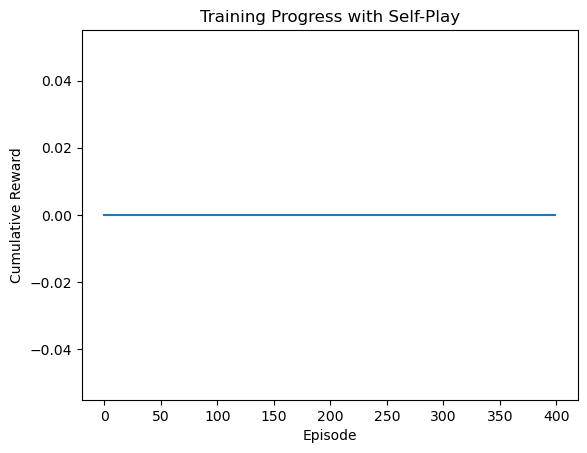

In [176]:
import random

# Opponent storage
opponent_policies = []

# Step 1: Set up the environment
env = boxing_v2.env(render_mode="rgb_array")
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)  # Resize frames to 84x84
env = dtype_v0(env, dtype="float32")  # Convert observations to float32
env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

parallel_env = aec_to_parallel(env)  # Convert to parallel format

# Step 2: Initialize PPO and RolloutBuffer
obs_shape = (1, 84, 84)  # Single frame (no stacking)
action_space = env.action_space("first_0")  # Example action space for an agent
ppo = PPO(obs_shape, action_space, lr=3e-5, gamma=0.9, epsilon=0.2, gae_lambda=0.95)

# Load pre-trained models if necessary
# ppo.load_value_network(value_model_path)  # load value network
ppo.load_policy_network(policy_model_path) # load policy network

# Initialize the buffer
buffer = RolloutBuffer()

# Tracking losses
episode_policy_losses = []
episode_value_losses = []
episode_total_losses = []

# Step 3: Training Loop
num_episodes = 400
max_steps_per_episode = 5000  # Maximum steps to prevent infinite loops
self_play_checkpoint_interval = 2  # Save the policy every N episodes for self-play
# Initialize reward tracking
cumulative_rewards = []

for episode in range(num_episodes):
    # Reset the environment
    observations = parallel_env.reset()

    # Extract nested observations (first element of the tuple)
    if isinstance(observations, tuple) and len(observations) > 0:
        agent_observations = observations[0]
    else:
        raise ValueError(f"Unexpected observation structure: {type(observations)}")

    # Initialize done flags for each agent
    done = {agent: False for agent in agent_observations.keys()}
    step = 0
    episode_reward = defaultdict(int)  # Track total reward for the episode

    # Choose an opponent policy for this episode
    if opponent_policies and random.random() < 0.5:
        opponent_policy = random.choice(opponent_policies)
    else:
        opponent_policy = None  # Use random actions if no opponent policy exists

    while not all(done.values()) and step < max_steps_per_episode:
        actions = {}
        log_probs = {}

        # Process observations for each agent
        for agent, obs in agent_observations.items():
            # Convert observations to grayscale if needed
            if obs.shape[-1] == 3:  # If RGB format
                obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels

            # Prepare tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

            # Decide the policy for each agent
            if agent == "first_0":
                # Use the current PPO policy for the first agent
                action_probs = ppo.policy.forward_policy(obs_tensor)
            else:
                # Use the opponent policy or random actions for the second agent
                if opponent_policy:
                    with torch.no_grad():
                        action_probs = opponent_policy(obs_tensor)
                else:
                    action_probs = torch.ones(action_space.n) / action_space.n  # Uniform random actions

            action = torch.multinomial(action_probs, 1).item()  # Sample action
            log_probs[agent] = torch.log(action_probs.squeeze(0)[action])  # Log probability
            actions[agent] = action  # Store action

        # Step the environment
        step_output = parallel_env.step(actions)

        if len(step_output) == 5:  # Handle truncations
            next_observations, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_observations, rewards, dones, infos = step_output

        # Extract nested observations for next step
        if isinstance(next_observations, dict):
            agent_observations = next_observations  # Observations are already in dictionary format
        else:
            raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")

        for agent, reward in rewards.items():
            episode_reward[agent] += reward
        
        # Store data in the buffer for each agent
        for agent, obs in agent_observations.items():
            buffer.store(obs, actions[agent], log_probs[agent].item(), rewards[agent], dones[agent])

        # Update done flags
        done = dones
        step += 1

    # Append episode reward
    cumulative_rewards.append(episode_reward)

    # Compute Returns and Advantages
    print(f"Episode {episode + 1}: Episode Reward = {episode_reward}")
    buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

    # Update PPO
    print(f"Episode {episode + 1}: Updating PPO model...")
    policy_losses, value_losses, total_losses = ppo.update(buffer)
    episode_policy_losses.append(np.mean(policy_losses))
    episode_value_losses.append(np.mean(value_losses))
    episode_total_losses.append(np.mean(total_losses))

    # Save the current policy for self-play periodically
    if (episode + 1) % self_play_checkpoint_interval == 0:
        saved_policy = PPOAgent(obs_shape, action_space)
        saved_policy.load_state_dict(ppo.policy.state_dict())
        opponent_policies.append(saved_policy)
        print(f"Checkpoint: Saved policy for self-play after Episode {episode + 1}")

    # Clear buffer for the next episode
    buffer.clear()

    # Log progress
    print(f"Episode {episode + 1}/{num_episodes} completed.")

# Plot cumulative rewards
plt.plot([sum(reward.values()) for reward in cumulative_rewards])
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress with Self-Play')
plt.show()


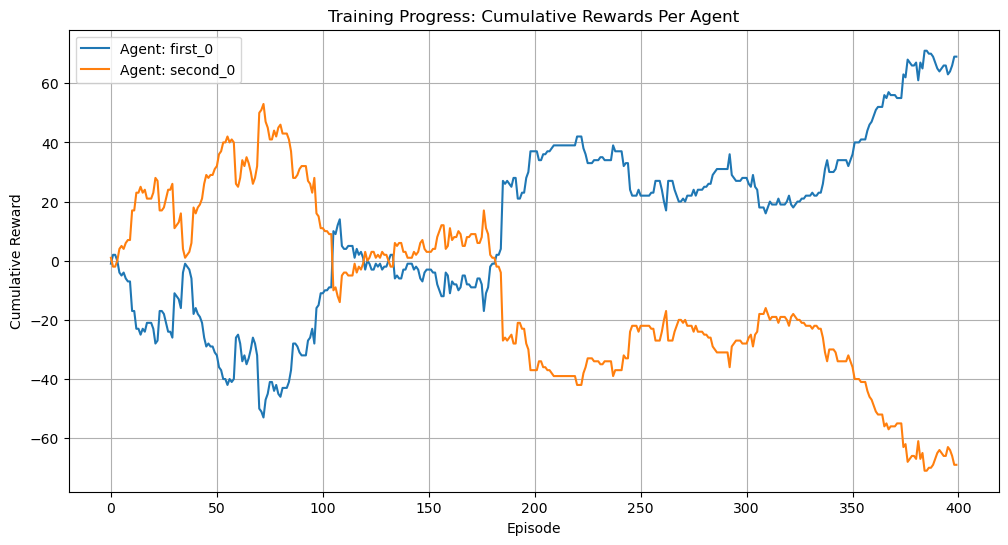

In [177]:
# Extract rewards for each agent
agent_rewards = {}
for episode_rewards in cumulative_rewards:
    for agent, reward in episode_rewards.items():
        if agent not in agent_rewards:
            agent_rewards[agent] = []
        agent_rewards[agent].append(reward)

# Plot cumulative rewards for each agent
plt.figure(figsize=(12, 6))
for agent, rewards in agent_rewards.items():
    cumulative_sum = np.cumsum(rewards)
    plt.plot(cumulative_sum, label=f"Agent: {agent}")

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress: Cumulative Rewards Per Agent')
plt.legend()
plt.grid(True)
plt.show()


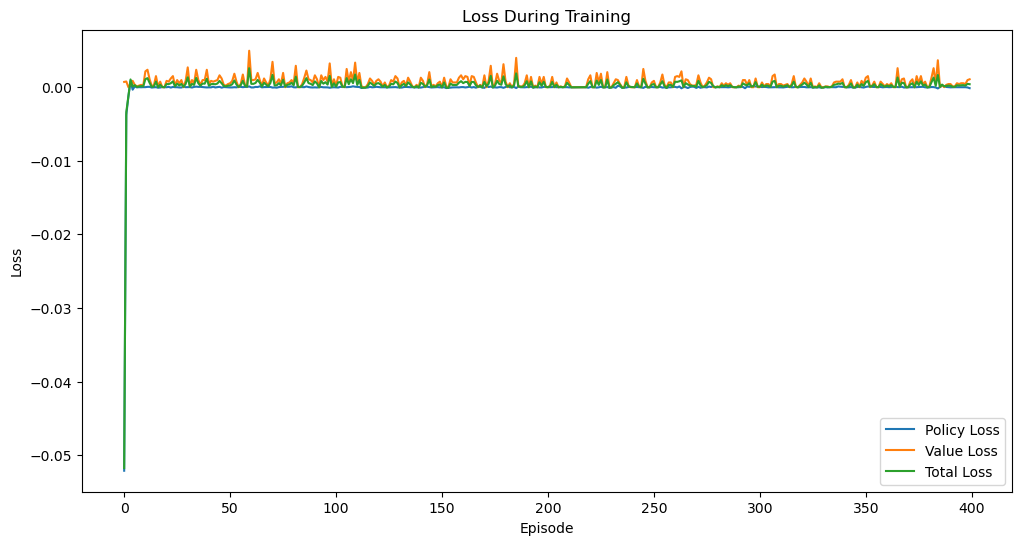

In [178]:
# Plotting losses after training
plt.figure(figsize=(12, 6))
plt.plot(episode_policy_losses, label="Policy Loss")
plt.plot(episode_value_losses, label="Value Loss")
plt.plot(episode_total_losses, label="Total Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()
plt.show()

In [179]:
save_dir = "ppo_Dec_15_full"
os.makedirs(save_dir, exist_ok=True)

# File paths for saving
policy_model_path = os.path.join(save_dir, "ppo_policy_model.pth")
value_model_path = os.path.join(save_dir, "ppo_value_model.pth")

In [180]:

# Save the trained PPO models
torch.save(ppo.policy.state_dict(), policy_model_path)
torch.save(ppo.policy.value_net.state_dict(), value_model_path)

print(f"Trained PPO models saved:")
print(f"Policy model: {policy_model_path}")
print(f"Value model: {value_model_path}")

Trained PPO models saved:
Policy model: ppo_Dec_15_full/ppo_policy_model.pth
Value model: ppo_Dec_15_full/ppo_value_model.pth


In [58]:
# for agent, reward in rewards.items():
#         if reward != 0:
#             print(f"step: {step}, Agent: {agent}, Reward: {reward}")
#         cumulative_rewards[agent] += reward

### Play against a Random Policy Agent

In [143]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import boxing_v2
from supersuit import (
    pad_observations_v0,
    pad_action_space_v0,
    resize_v1,
    dtype_v0,
    normalize_obs_v0
)

In [162]:
env.reset()
# Step 1: Set up the environment
env = boxing_v2.env(render_mode="rgb_array")
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)  # Resize frames to 84x84
env = dtype_v0(env, dtype="float32")  # Convert observations to float32
env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

In [181]:
# Load trained PPO model
policy_model_path = "ppo_Dec_15_full/ppo_policy_model.pth"  
ppo_agent = PPOAgent((1, 84, 84), env.action_space("first_0"))
ppo_agent.load_state_dict(torch.load(policy_model_path))

# Random policy function

Shape after conv layers: torch.Size([1, 64, 9, 9])


/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_1844/798413056.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ppo_agent.load_state_dict(torch.load(policy_mod

<All keys matched successfully>

In [182]:
import moviepy

print(dir(moviepy))

['AudioArrayClip', 'AudioClip', 'AudioFileClip', 'BitmapClip', 'Clip', 'ColorClip', 'CompositeAudioClip', 'CompositeVideoClip', 'DataVideoClip', 'Effect', 'ImageClip', 'ImageSequenceClip', 'TextClip', 'UpdatedVideoClip', 'VideoClip', 'VideoFileClip', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'afx', 'audio', 'clips_array', 'concatenate_audioclips', 'concatenate_videoclips', 'config', 'convert_to_seconds', 'decorators', 'display_in_notebook', 'ffmpeg_tools', 'tools', 'version', 'vfx', 'video', 'videotools']


In [192]:
from moviepy import ImageSequenceClip


def random_policy(action_space):
    return action_space.sample()

def play_match_and_save_video(env, ppo_agent, random_policy, video_path="fight_video.mp4", fps=30):
    """
    Play a match between the PPO agent and a random policy agent and save it as a video.

    Parameters:
    - env: The PettingZoo environment
    - ppo_agent: The trained PPO agent
    - random_policy: The random policy agent
    - video_path: Path to save the video
    - fps: Frames per second for the video

    Returns:
    - cumulative_rewards: A dictionary of cumulative rewards for each agent
    """
    # Reset the environment
    env.reset()

    # Initialize cumulative rewards and done flags
    done = {agent: False for agent in env.agents}
    cumulative_rewards = {agent: 0 for agent in env.agents}
    frames = []  # List to store video frames

    # Start playing the match
    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()

        # Add the reward for the current agent
        cumulative_rewards[agent] += reward

        # Check if the agent is done
        if termination or truncation:
            action = None  # No action for terminated agents
        else:
            # Preprocess observation
            if obs is not None and len(obs.shape) == 3 and obs.shape[-1] == 3:
                obs = obs.mean(axis=-1)  # Convert RGB to grayscale
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            # Decide action based on the agent (PPO vs. random policy)
            if agent == "first_0":  # PPO agent
                action_probs = ppo_agent.forward_policy(obs_tensor)
                action = torch.multinomial(action_probs, 1).item()
            else:
                action = random_policy(env.action_space(agent))  # Random policy 

        # Step the environment
        env.step(action)

        # Capture and store the frame
        frame = env.render()
        if frame is not None:
            frames.append(frame)

    # Save the video
    if frames:
        clip = ImageSequenceClip(frames, fps=fps)
        clip.write_videofile(video_path, codec="libx264")
        print(f"Video saved to {video_path}")
    else:
        print("No frames captured during the match. Video not saved.")

    return cumulative_rewards


In [193]:
# Run 10 matches and aggregate the results
num_matches = 1
all_match_results = []

for match in range(num_matches):
    # Play a match and save it as a video
    match_results = play_match_and_save_video(env, ppo_agent, random_policy, video_path="ppo_vs_random.mp4", fps=30)
    print("Match Results:", match_results)

    print(f"Match {match + 1} Results:", match_results)
    all_match_results.append(match_results)

# Aggregate results across matches
average_rewards = {agent: 0 for agent in all_match_results[0].keys()}
for match_result in all_match_results:
    for agent, reward in match_result.items():
        average_rewards[agent] += reward

# Calculate average rewards
average_rewards = {agent: reward / num_matches for agent, reward in average_rewards.items()}

# Visualize the average match results
agents = list(average_rewards.keys())
scores = list(average_rewards.values())

MoviePy - Building video ppo_vs_random.mp4.
MoviePy - Writing video ppo_vs_random.mp4



MoviePy - Done !
MoviePy - video ready ppo_vs_random.mp4
Video saved to ppo_vs_random.mp4
Match Results: {'first_0': 2, 'second_0': -2}
Match 1 Results: {'first_0': 2, 'second_0': -2}


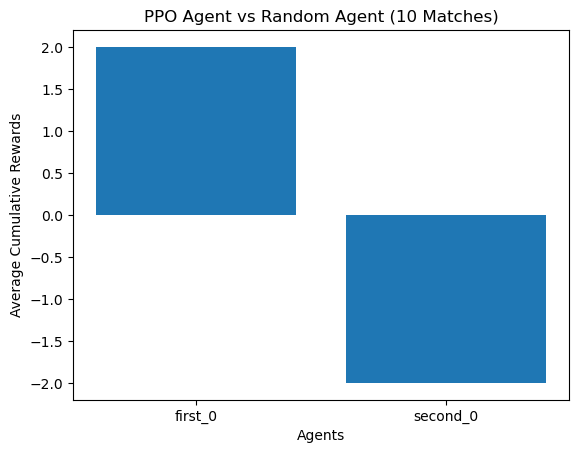

In [194]:
# bar plot of average rewards
plt.bar(agents, scores)
plt.xlabel("Agents")
plt.ylabel("Average Cumulative Rewards")
plt.title("PPO Agent vs Random Agent (10 Matches)")
plt.show()


### Run 10 matches to see the average rewards

In [186]:
def random_policy(action_space):
    return action_space.sample()

def play_matches(env, ppo_agent, random_policy, num_matches=10):
    """
    Play multiple matches between the PPO agent and a random policy agent and calculate average rewards.

    Parameters:
    - env: The PettingZoo environment
    - ppo_agent: The trained PPO agent
    - random_policy: The random policy agent
    - num_matches: Number of matches to play

    Returns:
    - average_rewards: A dictionary of average cumulative rewards for each agent
    """
    total_rewards = {agent: 0 for agent in env.agents}  # Initialize total rewards for all agents

    for match in range(num_matches):
        # Reset the environment
        env.reset()

        # Initialize cumulative rewards and done flags for the current match
        done = {agent: False for agent in env.agents}
        cumulative_rewards = {agent: 0 for agent in env.agents}

        # Start playing the match
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            # Add the reward for the current agent
            cumulative_rewards[agent] += reward

            # Check if the agent is done
            if termination or truncation:
                action = None  # No action for terminated agents
            else:
                # Preprocess observation
                if obs is not None and len(obs.shape) == 3 and obs.shape[-1] == 3:
                    obs = obs.mean(axis=-1)  # Convert RGB to grayscale
                obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

                # Decide action based on the agent (PPO vs. random policy)
                if agent == "first_0":  # PPO agent
                    action_probs = ppo_agent.forward_policy(obs_tensor)
                    action = torch.multinomial(action_probs, 1).item()
                else:
                    action = random_policy(env.action_space(agent))  # Random policy 

            # Step the environment
            env.step(action)

        # Update total rewards after the match
        for agent, reward in cumulative_rewards.items():
            total_rewards[agent] += reward

        print(f"Match {match + 1}/{num_matches} completed. Rewards: {cumulative_rewards}")

    # Calculate average rewards over all matches
    average_rewards = {agent: total_rewards[agent] / num_matches for agent in env.agents}
    return average_rewards



Match 1/10 completed. Rewards: {'first_0': 1, 'second_0': -1}
Match 2/10 completed. Rewards: {'first_0': -2, 'second_0': 2}
Match 3/10 completed. Rewards: {'first_0': -2, 'second_0': 2}
Match 4/10 completed. Rewards: {'first_0': -2, 'second_0': 2}
Match 5/10 completed. Rewards: {'first_0': 1, 'second_0': -1}
Match 6/10 completed. Rewards: {'first_0': -8, 'second_0': 8}
Match 7/10 completed. Rewards: {'first_0': 4, 'second_0': -4}
Match 8/10 completed. Rewards: {'first_0': 0, 'second_0': 0}
Match 9/10 completed. Rewards: {'first_0': -3, 'second_0': 3}
Match 10/10 completed. Rewards: {'first_0': 1, 'second_0': -1}
Match 1 Results: {'first_0': -10, 'second_0': 10}
Match 1/10 completed. Rewards: {'first_0': 3, 'second_0': -3}
Match 2/10 completed. Rewards: {'first_0': 7, 'second_0': -7}
Match 3/10 completed. Rewards: {'first_0': -3, 'second_0': 3}
Match 4/10 completed. Rewards: {'first_0': -11, 'second_0': 11}
Match 5/10 completed. Rewards: {'first_0': 4, 'second_0': -4}
Match 6/10 complet

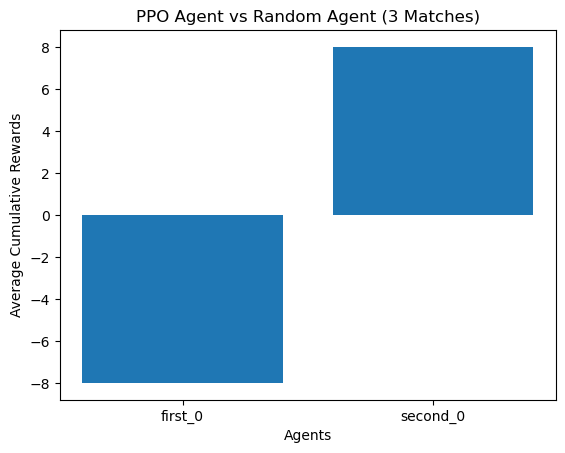

In [187]:
def random_policy(action_space):
    return action_space.sample()

def play_matches(env, ppo_agent, random_policy, num_matches=10):
    """
    Play multiple matches between the PPO agent and a random policy agent and calculate average rewards.

    Parameters:
    - env: The PettingZoo environment
    - ppo_agent: The trained PPO agent
    - random_policy: The random policy agent
    - num_matches: Number of matches to play

    Returns:
    - total_rewards: A dictionary of cumulative rewards for each agent across matches
    """
    total_rewards = {}  # Initialize total rewards for all agents dynamically

    for match in range(num_matches):
        # Reset the environment
        env.reset()

        # Initialize cumulative rewards and done flags for the current match
        cumulative_rewards = {}

        # Start playing the match
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            # Add the reward for the current agent
            if agent not in cumulative_rewards:
                cumulative_rewards[agent] = 0  # Initialize rewards for new agents
            cumulative_rewards[agent] += reward

            # Check if the agent is done
            if termination or truncation:
                action = None  # No action for terminated agents
            else:
                # Preprocess observation
                if obs is not None and len(obs.shape) == 3 and obs.shape[-1] == 3:
                    obs = obs.mean(axis=-1)  # Convert RGB to grayscale
                obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

                # Decide action based on the agent (PPO vs. random policy)
                if agent == "first_0":  # PPO agent
                    action_probs = ppo_agent.forward_policy(obs_tensor)
                    action = torch.multinomial(action_probs, 1).item()
                else:
                    action = random_policy(env.action_space(agent))  # Random policy 

            # Step the environment
            env.step(action)

        # Update total rewards after the match
        for agent, reward in cumulative_rewards.items():
            if agent not in total_rewards:
                total_rewards[agent] = 0  # Initialize rewards for new agents
            total_rewards[agent] += reward

        print(f"Match {match + 1}/{num_matches} completed. Rewards: {cumulative_rewards}")

    return total_rewards

# Run 10 matches and aggregate the results
num_matches = 3
all_match_results = []

for match in range(num_matches):
    match_results = play_matches(env, ppo_agent, random_policy)
    print(f"Match {match + 1} Results:", match_results)
    all_match_results.append(match_results)

# Aggregate results across matches
average_rewards = {agent: 0 for match_result in all_match_results for agent in match_result.keys()}
for match_result in all_match_results:
    for agent, reward in match_result.items():
        average_rewards[agent] += reward

# Calculate average rewards
average_rewards = {agent: reward / num_matches for agent, reward in average_rewards.items()}

# Visualize the average match results
agents = list(average_rewards.keys())
scores = list(average_rewards.values())

plt.bar(agents, scores)
plt.xlabel("Agents")
plt.ylabel("Average Cumulative Rewards")
plt.title(f"PPO Agent vs Random Agent ({num_matches} Matches)")
plt.show()


In [188]:
observations = env.reset()
print(observations)

None


In [189]:
# from pettingzoo.atari import boxing_v2

# # Initialize the raw environment
# raw_env = boxing_v2.env(render_mode="rgb_array")

# # Reset the environment
# raw_env.reset()

# # Access the first observation using `last()`
# obs, reward, termination, truncation, info = raw_env.last()
# print(f"Observation for current agent: {obs}")
# print(f"Reward: {reward}, Terminated: {termination}, Truncated: {truncation}")

# # If you want to iterate over all agents
# for agent in raw_env.agent_iter():
#     obs, reward, termination, truncation, info = raw_env.last()
#     print(f"Agent: {agent}, Observation: {obs}")


In [ ]:
env.reset()

actions = {agent: env.action_space(agent).sample() for agent in env.agents}
print(f"Sampled Actions: {actions}")


Sampled Actions: {'first_0': 12, 'second_0': 10}


In [ ]:
for agent in env.agents:
    action = env.action_space(agent).sample()
    print(f"Agent: {agent}, Sampled Action: {action}")


Agent: first_0, Sampled Action: 4
Agent: second_0, Sampled Action: 8


In [ ]:
print(dir(env))  # Check available attributes and methods
print(env.reset.__doc__)  # Print the docstring of the reset method if available


['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_accumulate_rewards', '_check_wrapper_params', '_clear_rewards', '_deads_step_first', '_has_rendered', '_has_reset', '_has_updated', '_is_protocol', '_modify_action', '_modify_observation', '_modify_spaces', '_update_step', '_was_dead_step', 'action_space', 'agent_iter', 'change_obs_space_fn', 'change_observation_fn', 'close', 'env', 'last', 'max_num_agents', 'num_agents', 'observation_space', 'observe', 'render', 'reset', 'state', 'step', 'unwrapped']
None


step: 2159, Agent: first_0, Reward: 1
step: 2159, Agent: second_0, Reward: -1
step: 3267, Agent: first_0, Reward: -1
step: 3267, Agent: second_0, Reward: 1
step: 3859, Agent: first_0, Reward: 1
step: 3859, Agent: second_0, Reward: -1
step: 5587, Agent: first_0, Reward: -2
step: 5587, Agent: second_0, Reward: 2
step: 6301, Agent: first_0, Reward: -1
step: 6301, Agent: second_0, Reward: 1
step: 7098, Agent: first_0, Reward: -1
step: 7098, Agent: second_0, Reward: 1
step: 7114, Agent: first_0, Reward: -1
step: 7114, Agent: second_0, Reward: 1
step: 7132, Agent: first_0, Reward: -1
step: 7132, Agent: second_0, Reward: 1
Cumulative Rewards: defaultdict(<class 'int'>, {'first_0': -5, 'second_0': 5})


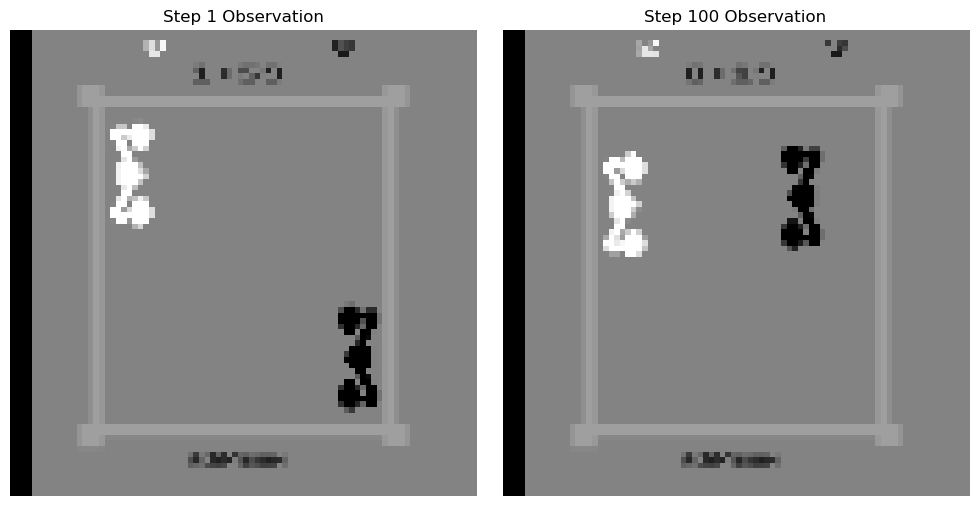

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Reset the environment
observations = parallel_env.reset()

# Initialize a variable to store observations
step_1_observation = None
step_100_observation = None
cumulative_rewards = defaultdict(int)

for step in range(8000):
    # Sample random actions for all agents
    actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}

    # Step the environment
    step_output = parallel_env.step(actions)

    if len(step_output) == 5:  # Handle truncations
        next_observations, rewards, dones, truncations, infos = step_output
        dones = {agent: dones[agent] or truncations[agent] for agent in dones}
    else:
        next_observations, rewards, dones, infos = step_output

    
    # Store the first and 100th observations
    if step == 0:
        step_1_observation = next_observations.copy()
    if step == 5999:
        step_100_observation = next_observations.copy()

    for agent, reward in rewards.items():
        if reward != 0:
            print(f"step: {step}, Agent: {agent}, Reward: {reward}")
        cumulative_rewards[agent] += reward
    
    # Break if the environment is done
    if all(dones.values()):
        break


print(f"Cumulative Rewards: {cumulative_rewards}")

# Visualize the observations for the first and 100th steps
agent = list(next_observations.keys())[0]  # Pick the first agent for visualization

# Convert the observations to grayscale if they are in RGB format
def preprocess_observation(obs):
    if len(obs.shape) == 3 and obs.shape[-1] == 3:  # RGB format
        obs = np.mean(obs, axis=-1)  # Convert to grayscale
    return obs

step_1_frame = preprocess_observation(step_1_observation[agent])
step_100_frame = preprocess_observation(step_100_observation[agent])

# Plot the frames
plt.figure(figsize=(10, 5))

# Step 1 observation
plt.subplot(1, 2, 1)
plt.imshow(step_1_frame, cmap='gray')
plt.title("Step 1 Observation")
plt.axis('off')

# Step 100 observation
plt.subplot(1, 2, 2)
plt.imshow(step_100_frame, cmap='gray')
plt.title("Step 100 Observation")
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# for agent, obs in next_observations.items():
#     plt.imshow(obs)  # Assuming observations are raw frames
#     plt.title(f"Agent: {agent}")
#     plt.show()

print(env.rewards.__doc__)  # Print the docstring of the rewards method if available



dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [ ]:
# # Step 1: Set up the environment
# env = boxing_v2.env(render_mode="rgb_array")
# env.reset(seed=42)
# env = frame_skip_v0(env, 4)  # Frame skipping
# env = pad_observations_v0(env)
# env = pad_action_space_v0(env)
# env = resize_v1(env, 84, 84)  # Resize frames to 84x84
# env = dtype_v0(env, dtype="float32")  # Convert observations to float32
# env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

# parallel_env = aec_to_parallel(env)  # Convert to parallel format

# # Step 2: Initialize PPO and RolloutBuffer
# obs_shape = (1, 84, 84)  # Single frame (no stacking)
# action_space = env.action_space("first_0")  # Example action space for an agent
# ppo = PPO(obs_shape, action_space)
# buffer = RolloutBuffer()

# # Step 3: Training Loop
# num_episodes = 5
# max_steps_per_episode = 3000  # Maximum steps to prevent infinite loops
# # Initialize reward tracking
# cumulative_rewards = []

# for episode in range(num_episodes):
#     # Reset the environment
#     observations = parallel_env.reset()

#     # Extract nested observations (first element of the tuple)
#     if isinstance(observations, tuple) and len(observations) > 0:
#         agent_observations = observations[0]
#     else:
#         raise ValueError(f"Unexpected observation structure: {type(observations)}")

#     # Initialize done flags for each agent
#     done = {agent: False for agent in parallel_env.agents} # updated for skipping***********************************************
#     step = 0
#     episode_reward = defaultdict(int)  # Track total reward for the episode

#     while not all(done.values()) and step < max_steps_per_episode:
#         actions = {}
#         log_probs = {}

#         # Process observations for each agent
#         for agent in parallel_env.agents:
#             # print(f"Agent: {agent}")
#             if done[agent]:
#                 # Provide a placeholder action for done agents
#                 actions[agent] = parallel_env.action_space(agent).sample()
#             else:
#                 obs = agent_observations[agent]
#                 if obs.shape[-1] == 3:  # If RGB format
#                     obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels
#                 obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
#                 action_probs = ppo.policy.forward_policy(obs_tensor)
#                 action = torch.multinomial(action_probs, 1).item()
#                 actions[agent] = action


#         # Step the environment
#         try:
#             step_output = parallel_env.step(actions)
#         except AssertionError as e:
#             # Handle any unexpected sequence errors
#             print(f"Assertion Error: {e}")
#             break

#         # Handle the step output
#         if len(step_output) == 5:  # Handle truncations
#             next_observations, rewards, dones, truncations, infos = step_output
#             dones = {agent: dones.get(agent, False) or truncations.get(agent, False) for agent in parallel_env.agents}
#         else:
#             next_observations, rewards, dones, infos = step_output

#         # Update done flags
#         done = {agent: dones.get(agent, False) for agent in parallel_env.agents}

#         # Ensure `agent_observations` and other dictionaries are in sync
#         if isinstance(next_observations, dict):
#             agent_observations = {agent: next_observations.get(agent, None) for agent in parallel_env.agents}
#         else:
#             raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")

#         # Update rewards and store observations in the buffer
#         for agent in parallel_env.agents:
#             if not done.get(agent, False):
#                 obs = agent_observations.get(agent)
#                 if obs is None:
#                     print(f"Warning: Missing observation for agent {agent} at step {step}. Skipping.")
#                     continue
#                 buffer.store(
#                     obs,
#                     actions.get(agent, parallel_env.action_space(agent).sample()),
#                     log_probs.get(agent, 0.0),
#                     rewards.get(agent, 0.0),
#                     done.get(agent, False)
#                 )
#                 episode_reward[agent] += rewards.get(agent, 0.0)

#         # Ensure buffer is not empty
#         if len(buffer.observations) == 0:
#             print(f"Warning: Buffer is empty after step {step}.")

#         # Update done flags
#         done = {agent: dones[agent] or truncations[agent] for agent in parallel_env.agents}
#         step += 1

#     # Append episode reward
#     cumulative_rewards.append(episode_reward)

#     # Compute Returns and Advantages
#     print(f"Episode {episode + 1}: Episode Reward = {episode_reward}")
#     buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

#     # Update PPO
#     print(f"Episode {episode + 1}: Updating PPO model...")
#     ppo.update(buffer)

#     # Clear buffer for the next episode
#     buffer.clear()

#     # Log progress
#     print(f"Episode {episode + 1}/{num_episodes} completed.")


In [ ]:
# for episode in range(num_episodes):
#     # Reset the environment
#     observations = parallel_env.reset()

#     # Extract nested observations (first element of the tuple)
#     if isinstance(observations, tuple) and len(observations) > 0:
#         agent_observations = observations[0]
#     else:
#         raise ValueError(f"Unexpected observation structure: {type(observations)}")

#     # Initialize done flags for each agent
#     done = {agent: False for agent in agent_observations.keys()}
#     step = 0

#     while not all(done.values()) and step < max_steps_per_episode:
#         actions = {}
#         log_probs = {}

#         # Process observations for each agent
#         for agent, obs in agent_observations.items():
#             # Convert observations to grayscale if needed
#             if obs.shape[-1] == 3:  # If RGB format
#                 obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels

#             # Prepare tensor with correct dimensions
#             obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

#             # Get action probabilities
#             action_probs = ppo.policy.forward_policy(obs_tensor)
#             action = torch.multinomial(action_probs, 1).item()  # Sample action
#             log_probs[agent] = torch.log(action_probs.squeeze(0)[action])  # Log probability
#             actions[agent] = action  # Store action

#         # Step the environment
#         step_output = parallel_env.step(actions)

#         if len(step_output) == 5:  # Handle truncations
#             next_observations, rewards, dones, truncations, infos = step_output
#             dones = {agent: dones[agent] or truncations[agent] for agent in dones}
#         else:
#             next_observations, rewards, dones, infos = step_output

#         # Extract nested observations for next step
#         if isinstance(next_observations, dict):
#             agent_observations = next_observations  # Observations are already in dictionary format
#         else:
#             raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")


#         # Store data in the buffer for each agent
#         for agent, obs in agent_observations.items():
#             buffer.store(obs, actions[agent], log_probs[agent].item(), rewards[agent], dones[agent])

#         # Update done flags
#         done = dones
#         step += 1

#     # Compute Returns and Advantages
#     print(f"Episode {episode + 1}: Computing returns and advantages...")
#     buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

#     # Update PPO
#     print(f"Episode {episode + 1}: Updating PPO model...")
#     ppo.update(buffer)

#     # Clear buffer for the next episode
#     buffer.clear()

#     # Log progress
#     print(f"Episode {episode + 1}/{num_episodes} completed.")